### This Kernel is recreated from https://www.kaggle.com/arindamgot/eda-prophet-mlp-neural-network-forecasting/notebook and converted to python

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
plt.style.use('ggplot')

In [5]:
data_folder = "D:\\kaggleDatasets\\demand-forecasting-kernels-only\\"
path = data_folder + "train.csv"
train = pd.read_csv(path)
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
train.shape

(913000, 4)

In [8]:
train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
train.head()

,date,store,item,sales,year,month,month_year
0,2013-01-01,1,1,13,2013,1,2013-01
1,2013-01-02,1,1,11,2013,1,2013-01
2,2013-01-03,1,1,14,2013,1,2013-01
3,2013-01-04,1,1,13,2013,1,2013-01
4,2013-01-05,1,1,10,2013,1,2013-01


In [9]:
# train.count() will give a value only if not nan
count_nan = len(train) - train.count()
count_nan

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


date          0
store         0
item          0
sales         0
year          0
month         0
month_year    0
dtype: int64

## 4. Individual Feature Visualization

### 4.1 Histogram of sales of an item (daily sales amount)
"histogram of daily sales price"

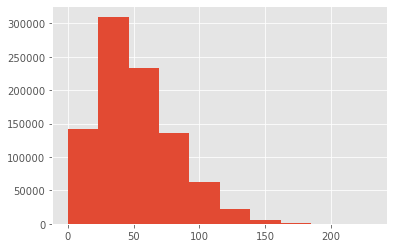

In [11]:
plt.hist(train["sales"])
plt.show()

#### Sales is positively skewed.

### 4.2 "Growth" (?) of sales price by date and change of rate of sales price

In [13]:
mean_sales = train.groupby(["date"], as_index=False)
mean_sales = mean_sales[["sales"]].mean()
mean_sales["idx"] = mean_sales.index

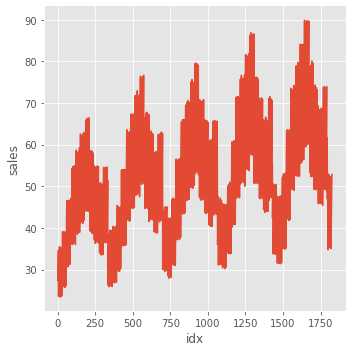

In [14]:
g = sns.relplot(x="idx", y="sales", data=mean_sales, kind="line")

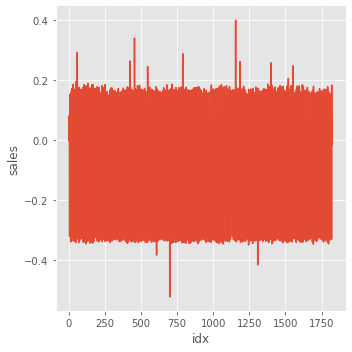

In [16]:
rt = pd.Series(mean_sales["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

#### You can see that sales growth is multiplicative with increasing trend and seasonality.


### 4.3 Sales growth monthly

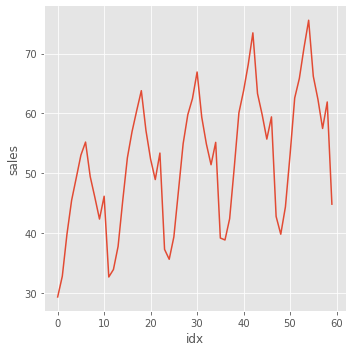

In [17]:
mean_sales_monthly = train.groupby(["month_year"], as_index=False)
mean_sales_monthly = mean_sales_monthly[["sales"]].mean()
mean_sales_monthly["idx"] = mean_sales_monthly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_monthly, kind="line")

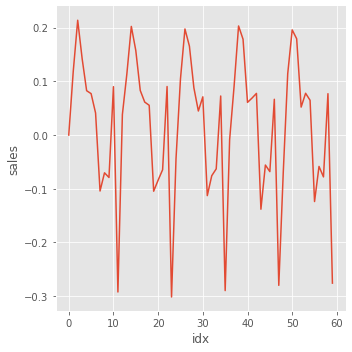

In [18]:
rt = pd.Series(mean_sales_monthly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

#### We can confirm that sales are multipliative with increasing trend and seasonality.

### 4.4 Growth by Year

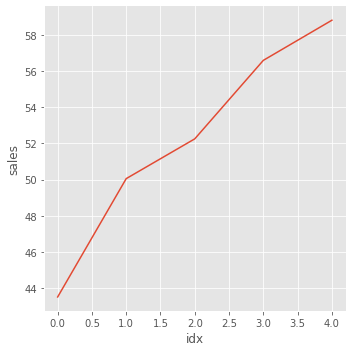

In [19]:
mean_sales_yearly = train.groupby(["year"], as_index=False)
mean_sales_yearly = mean_sales_yearly[["sales"]].mean()
mean_sales_yearly["idx"] = mean_sales_yearly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_yearly, kind="line")

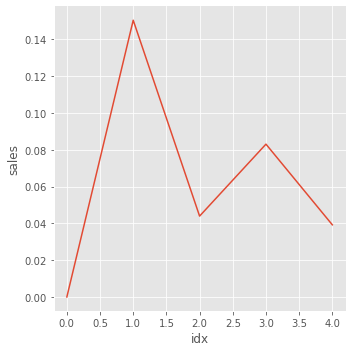

In [20]:
rt = pd.Series(mean_sales_yearly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

#### Growth of sales increases yearly, but the change in sales is different per year. Rate of change of sales decreased from 2014 to 2015, increased to 2016, then dropped.


### 4.5 Sales growth by store

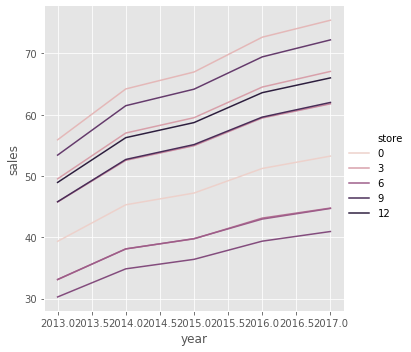

In [21]:
data = train.groupby(['store',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="store")

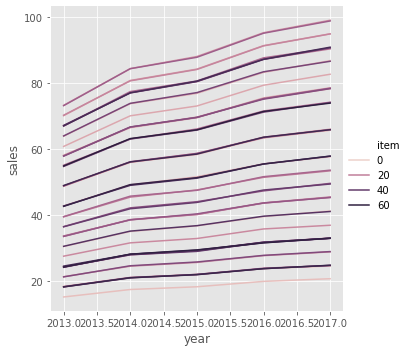

In [22]:
data = train.groupby(['item',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="item")

## 5. Prophet Model
### 5.4 Building the model for store = 1, product = 1

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
s1i1 = train[(train["store"]==1) & (train["item"])==1]
s1i1["sales"] = np.log1p(s1i1["sales"])
s1i1.head()

,date,store,item,sales,year,month,month_year
0,2013-01-01,1,1,2.639057,2013,1,2013-01
1,2013-01-02,1,1,2.484907,2013,1,2013-01
2,2013-01-03,1,1,2.708050,2013,1,2013-01
3,2013-01-04,1,1,2.639057,2013,1,2013-01
4,2013-01-05,1,1,2.397895,2013,1,2013-01


In [26]:
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [27]:
m = Prophet()
m.fit(stats)
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
46010,2018-12-27
46011,2018-12-28
46012,2018-12-29
46013,2018-12-30
46014,2018-12-31


In [28]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46010,2018-12-27,3.540535,2.912370,4.191984
46011,2018-12-28,3.603183,2.931008,4.241717
46012,2018-12-29,3.666020,3.008314,4.359995
46013,2018-12-30,3.721309,3.094945,4.331295
46014,2018-12-31,3.317836,2.709130,3.997225


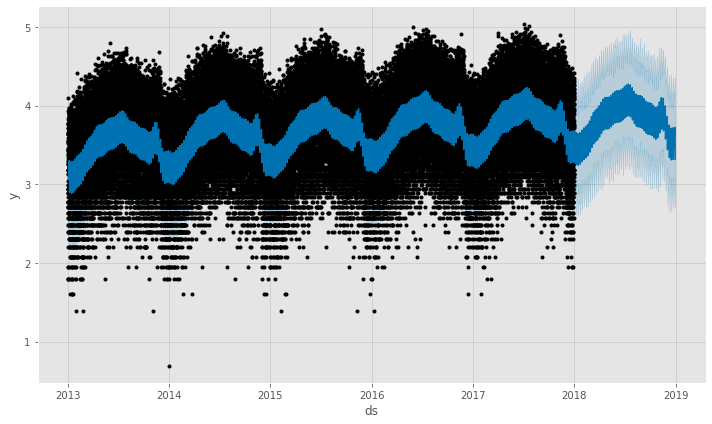

In [29]:
fig1 = m.plot(forecast)

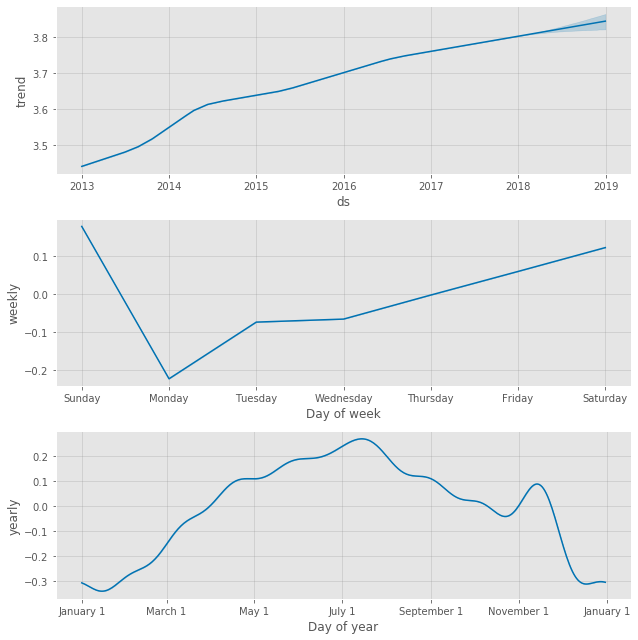

In [30]:
fig2 = m.plot_components(forecast)

#### We see sales drop from Sunday to Monday so there must be a holiday effect in the sales data. There's a peak in July so this may be due to seasonal sales or summer festivities.

#### Next step, try excluding change points and include holiday effects. Let's count NFL playoffs as a holiday. And add an extra regressor for NFL sundays.

In [31]:
playoffs = ['2013-07-12', '2014-07-12', '2014-07-19',
                 '2014-07-02', '2015-07-11', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24']
superbowl = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
                '2017-01-01', '2017-12-25']

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(playoffs),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(superbowl),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [32]:
s1i1["dow"] = pd.to_datetime(s1i1["date"]).dt.day_name() # day of week
s1i1.head()

,date,store,item,sales,year,month,month_year,dow
0,2013-01-01,1,1,2.639057,2013,1,2013-01,Tuesday
1,2013-01-02,1,1,2.484907,2013,1,2013-01,Wednesday
2,2013-01-03,1,1,2.708050,2013,1,2013-01,Thursday
3,2013-01-04,1,1,2.639057,2013,1,2013-01,Friday
4,2013-01-05,1,1,2.397895,2013,1,2013-01,Saturday


In [33]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

In [34]:
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [36]:
# Python
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

In [44]:
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [45]:
stats["nfl_sunday"] = stats['ds'].apply(nfl_sunday)
stats.head()

,ds,y,nfl_sunday
0,2013-01-01,2.639057,0
1,2013-01-02,2.484907,0
2,2013-01-03,2.708050,0
3,2013-01-04,2.639057,0
4,2013-01-05,2.397895,0


In [46]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
m.add_regressor('nfl_sunday')
m.add_seasonality(name='daily', period=60, fourier_order=5)
m.fit(stats)

In [47]:
stats.head()

,ds,y,nfl_sunday
0,2013-01-01,2.639057,0
1,2013-01-02,2.484907,0
2,2013-01-03,2.708050,0
3,2013-01-04,2.639057,0
4,2013-01-05,2.397895,0


In [48]:
future = m.make_future_dataframe(periods=90, freq="D") # Daily frequency
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
future.tail()

,ds,nfl_sunday
45735,2018-03-27,0
45736,2018-03-28,0
45737,2018-03-29,0
45738,2018-03-30,0
45739,2018-03-31,0


In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45735,2018-03-27,3.739137,2.723240,4.757692
45736,2018-03-28,3.751478,2.731543,4.736824
45737,2018-03-29,3.819279,2.808527,4.802099
45738,2018-03-30,3.886086,2.833301,4.915754
45739,2018-03-31,3.953254,2.947065,4.943747


In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

### 5.8 SMAPE Calcuation¶

In [55]:
ps1i1 = forecast[["ds"]]
ps1i1["forecast"] = np.expm1(forecast["yhat"])
ps1i1["yearmonth"] = pd.to_datetime(ps1i1["ds"]).dt.to_period("M")
ps1i1.head()

,ds,forecast,yearmonth
0,2013-01-01,19.784235,2013-01
1,2013-01-01,19.784235,2013-01
2,2013-01-01,19.784235,2013-01
3,2013-01-01,19.784235,2013-01
4,2013-01-01,19.784235,2013-01


In [56]:
def smape(outsample, forecast):
    num = np.abs(outsample-forecast)
    denom = np.abs(outsample) + np.abs(forecast)
    return (num/denom)/2

stats["ds"] = pd.to_datetime(stats["ds"])

In [57]:
ps1i1["ds"] = pd.to_datetime(ps1i1["ds"])

In [58]:
train_predict = stats.merge(ps1i1)

In [59]:
smape_err = smape(train_predict["y"], train_predict["forecast"])
smape_err = smape_err[~np.isnan(smape_err)]
np.mean(smape_err)

0.41070161038837494

### 5.9 Automated forecasting with Prophet: Splitting data by store and item

In [60]:
train["sales"] = np.log1p(train["sales"]) 

In [61]:
train.columns = ["ds", "store", "item", "sales", "y", "m", "my"]
train.head()

,ds,store,item,sales,y,m,my
0,2013-01-01,1,1,2.639057,2013,1,2013-01
1,2013-01-02,1,1,2.484907,2013,1,2013-01
2,2013-01-03,1,1,2.708050,2013,1,2013-01
3,2013-01-04,1,1,2.639057,2013,1,2013-01
4,2013-01-05,1,1,2.397895,2013,1,2013-01


In [62]:
def make_prediction(df):
    
    playoffs = ['2013-07-12', '2014-07-12', '2014-07-19',
                 '2014-07-02', '2015-07-11', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24']
    superbowl = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
                    '2017-01-01', '2017-12-25']

    playoffs = pd.DataFrame({
      'holiday': 'playoff',
      'ds': pd.to_datetime(playoffs),
      'lower_window': 0,
      'upper_window': 1,
    })
    superbowls = pd.DataFrame({
      'holiday': 'superbowl',
      'ds': pd.to_datetime(superbowl),
      'lower_window': 0,
      'upper_window': 1,
    })
    holidays = pd.concat((playoffs, superbowls))
    
    m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
    m.add_seasonality(name='daily', period=60, fourier_order=5)
    m.fit(df)
    future = m.make_future_dataframe(periods=90)
    forecast = m.predict(future)
    return forecast

In [63]:
df = train[(train["store"]==1) & (train["item"] ==2)]
df = df[["ds", "sales"]]
df.columns = ["ds", "y"]
df.head()

,ds,y
18260,2013-01-01,3.526361
18261,2013-01-02,3.784190
18262,2013-01-03,3.178054
18263,2013-01-04,2.944439
18264,2013-01-05,3.555348


In [64]:
prediction = make_prediction(df)
prediction[["ds", "yhat"]].tail()

,ds,yhat
1911,2018-03-27,4.045995
1912,2018-03-28,4.064189
1913,2018-03-29,4.127403
1914,2018-03-30,4.187852
1915,2018-03-31,4.258109
